# IDA and EDA Analysis

## Dataset

The dataset was created by scraping data from Reddit API (Praw), as outlined in the file 'scraping.py'. The python file output the scraped data on AI posts as 'reddit_ai.csv'. 


What the columns/features are:

| Column                     | Meaning / How it's formed                                                                                                                                                                               |
| -------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **subreddit**              | The name of the subreddit where the post was made.                                                                                                                             |
| **title**                  | The title of the Reddit post.                                                                                                                                                                           |
| **selftext**               | The body text of the post (for text posts only).                                                                                                                          |
| **score**                  | The Reddit score (upvotes minus downvotes) at the time of scraping.                                     |
| **upvote_ratio**           | Ratio of upvotes to total votes (upvotes / (upvotes + downvotes)). Ranges from 0 to 1.                          |
| **id**                     | The Reddit post ID, unique identifier for each post.                                                                                                                                                    |
| **url**                    | Direct link to the Reddit post.                                                                                                                                                                         |
| **created_utc**            | Timestamp of when the post was created, in **UTC seconds since epoch**.                                                                                                                                 |
| **num_comments**           | Number of comments on the post at the time of scraping.                                                                                                                                                 |
| **post_length**            | Number of words in the full text of the post (`title + selftext`).                                                                                                                                      |
| **title_length**           | Number of words in the post’s title only.                                                                                                                                                               |
| **sentiment_polarity**     | A score from **TextBlob** representing sentiment: ranges from -1 (very negative) to +1 (very positive).                            |
| **sentiment_subjectivity** | A score from **TextBlob** representing how subjective the post is: ranges from 0 (very objective/factual) to 1 (very subjective/opinionated). |


In [1]:
#imports
import pandas as pd
import numpy as np
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [9]:
df = pd.read_csv("../data/reddit_ai.csv")

In [10]:
df.head()

,subreddit,title,selftext,score,upvote_ratio,id,url,created_utc,num_comments,post_length,title_length,sentiment_polarity,sentiment_subjectivity
0,MachineLearning,[R] How to retrieve instructions given to anno...,"Hello,\n\r\nI am a communications student, and...",13,0.93,1o2vmex,https://www.reddit.com/r/MachineLearning/comme...,1.760086e+09,7,171,10,0.095833,0.404333
1,MachineLearning,[D] 🧬 Built an ML-based Variant Impact Predict...,"Hey folks,\n\nI’ve been working on a small ML ...",0,0.40,1o2e3t9,https://www.reddit.com/r/MachineLearning/comme...,1.760035e+09,10,244,14,0.131198,0.393388
2,MachineLearning,[D] Tensorflow and Musicnn,"Hi all,\nI’m struggling with Tensorflow and an...",1,0.57,1nzcg16,https://www.reddit.com/r/MachineLearning/comme...,1.759735e+09,11,386,4,0.135743,0.404892
3,MachineLearning,[D] Experiences with active learning for real ...,I'm tinkering with an application of human pos...,4,0.83,1ny6ol1,https://www.reddit.com/r/MachineLearning/comme...,1.759615e+09,6,310,8,-0.025505,0.501641
4,MachineLearning,[R] Thesis direction: mechanistic interpretabi...,"Hi all,\n\nI'm an undergrad Computer Science s...",12,0.80,1nwfn4j,https://www.reddit.com/r/MachineLearning/comme...,1.759438e+09,13,165,11,0.219318,0.450271


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   subreddit               462 non-null    object 
 1   title                   462 non-null    object 
 2   selftext                462 non-null    object 
 3   score                   462 non-null    int64  
 4   upvote_ratio            462 non-null    float64
 5   id                      462 non-null    object 
 6   url                     462 non-null    object 
 7   created_utc             462 non-null    float64
 8   num_comments            462 non-null    int64  
 9   post_length             462 non-null    int64  
 10  title_length            462 non-null    int64  
 11  sentiment_polarity      462 non-null    float64
 12  sentiment_subjectivity  462 non-null    float64
dtypes: float64(4), int64(4), object(5)
memory usage: 47.1+ KB


In [12]:
df.describe()

,score,upvote_ratio,created_utc,num_comments,post_length,title_length,sentiment_polarity,sentiment_subjectivity
count,462.000000,462.000000,4.620000e+02,462.000000,462.000000,462.000000,462.000000,462.000000
mean,82.638528,0.728377,1.755487e+09,38.523810,410.790043,12.898268,0.108603,0.468703
std,290.788317,0.245308,5.791673e+06,108.786595,507.119723,8.542889,0.097137,0.080930
min,0.000000,0.100000,1.732166e+09,1.000000,31.000000,1.000000,-0.261667,0.303571
25%,1.000000,0.560000,1.754095e+09,3.000000,155.250000,8.000000,0.055227,0.415954
50%,6.000000,0.810000,1.757448e+09,11.000000,238.000000,11.000000,0.104875,0.459375
75%,28.750000,0.927500,1.759544e+09,28.000000,436.250000,15.000000,0.158843,0.510791
max,2834.000000,1.000000,1.760483e+09,1437.000000,5501.000000,51.000000,0.808333,0.728333


## Cleaning and Pre-Processing

Even though there's no null or missing values in the dataset, we need to do a wide range of cleaning before the dataframe can be ready to go through machine learning and NLP methods.

In [13]:
def clean_text(text):
    """Remove URLs, special characters, extra whitespace"""
    if pd.isna(text) or text == '':
        return ''
    
    text = str(text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    
    # Remove Reddit markdown links [text](url)
    text = re.sub(r'\[([^\]]+)\]\([^\)]+\)', r'\1', text)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove subreddit/user mentions
    text = re.sub(r'r/\w+', '', text)
    text = re.sub(r'u/\w+', '', text)
    
    # Remove Reddit post type tags [D], [R], [P], [Q], [N], etc.
    text = re.sub(r'\[[A-Z]\]', '', text)
    
    # Keep only letters, numbers, spaces, and basic punctuation
    text = re.sub(r'[^a-zA-Z0-9\s\.\,\!\?\-\'\[\]]', ' ', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply cleaning
df['title_clean'] = df['title'].apply(clean_text)
df['selftext_clean'] = df['selftext'].apply(clean_text)

In [14]:
# Drop id and url - not needed for analysis
df = df.drop(columns=['id', 'url'])

In [15]:
# Convert created_utc to datetime and extract components
df['created_datetime'] = pd.to_datetime(df['created_utc'], unit='s')
df['date'] = df['created_datetime'].dt.date
df['year'] = df['created_datetime'].dt.year

# Drop the original created_utc column (we have created_datetime now)
df = df.drop(columns=['created_utc'])

In [16]:
cleaned_df = df[['title_clean', 'selftext_clean', 'subreddit', 'score', 'upvote_ratio', 'num_comments', 'post_length', 'sentiment_polarity','sentiment_subjectivity','created_datetime', 'date', 'year']]

In [17]:
# cleaned_df.to_csv('reddit_ai_cleaned.csv', index=False)

In [18]:
cleaned_df.head()

,title_clean,selftext_clean,subreddit,score,upvote_ratio,num_comments,post_length,sentiment_polarity,sentiment_subjectivity,created_datetime,date,year
0,How to retrieve instructions given to annotato...,"Hello, I am a communications student, and as p...",MachineLearning,13,0.93,7,171,0.095833,0.404333,2025-10-10 08:49:17,2025-10-10,2025
1,Built an ML-based Variant Impact Predictor non...,"Hey folks, I ve been working on a small ML pro...",MachineLearning,0,0.40,10,244,0.131198,0.393388,2025-10-09 18:40:15,2025-10-09,2025
2,Tensorflow and Musicnn,"Hi all, I m struggling with Tensorflow and an ...",MachineLearning,1,0.57,11,386,0.135743,0.404892,2025-10-06 07:19:05,2025-10-06,2025
3,Experiences with active learning for real appl...,I'm tinkering with an application of human pos...,MachineLearning,4,0.83,6,310,-0.025505,0.501641,2025-10-04 21:53:21,2025-10-04,2025
4,Thesis direction mechanistic interpretability ...,"Hi all, I'm an undergrad Computer Science stud...",MachineLearning,12,0.80,13,165,0.219318,0.450271,2025-10-02 20:50:44,2025-10-02,2025


In [29]:
# checking amount of outliers in the data
Q1 = cleaned_df['score'].quantile(0.25)
Q3 = cleaned_df['score'].quantile(0.75)
IQR = Q3 - Q1
outliers = cleaned_df[(cleaned_df['score'] < Q1 - 1.5*IQR) | 
                      (cleaned_df['score'] > Q3 + 1.5*IQR)]
print(f"Score outliers: {len(outliers)}")

Score outliers: 77


## Visualizations

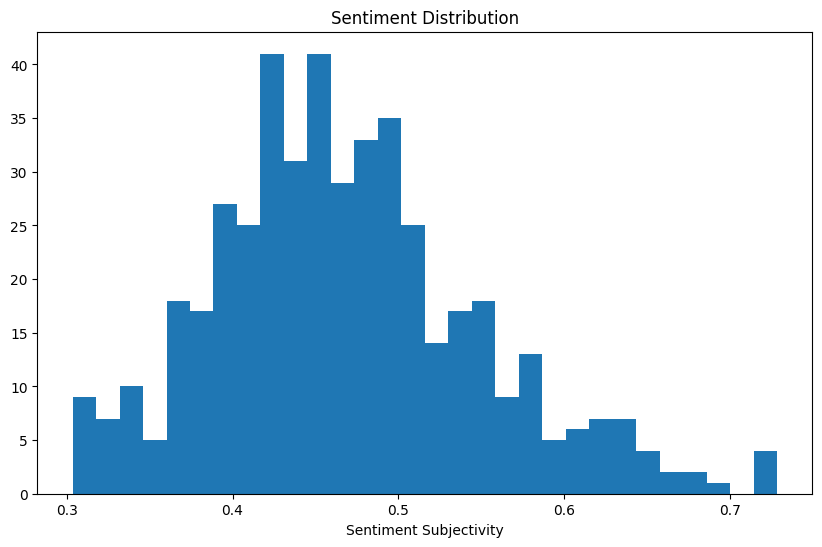

In [20]:
# Sentiment distribution
plt.figure(figsize=(10, 6))
plt.hist(cleaned_df['sentiment_subjectivity'], bins=30)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Subjectivity')
plt.show()

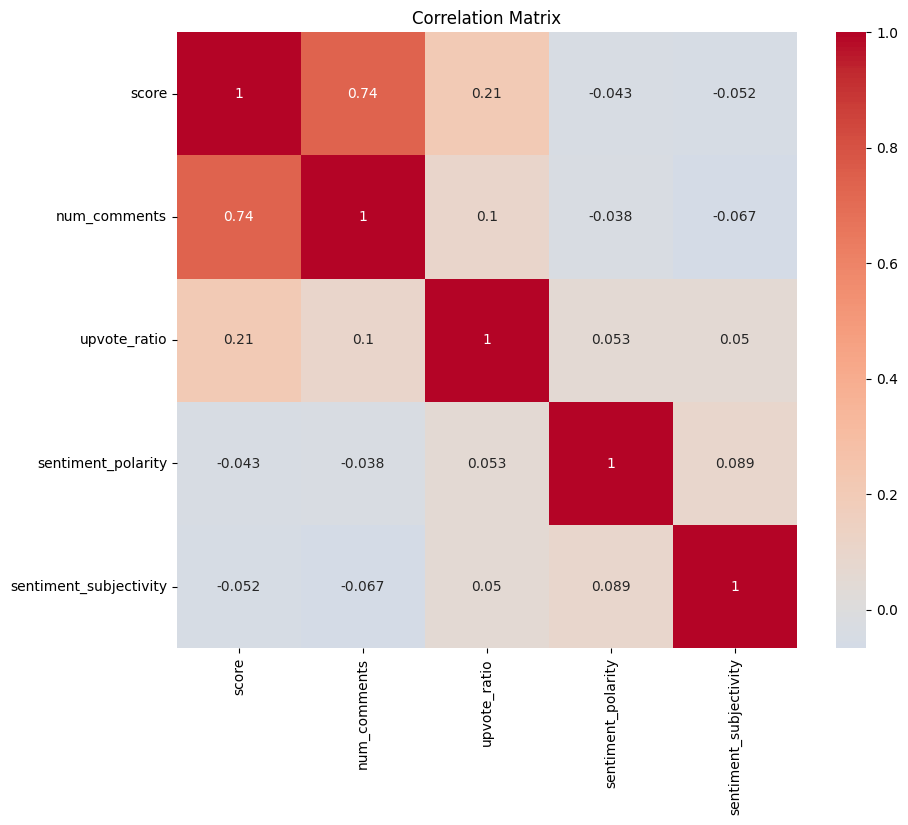

In [21]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
corr = cleaned_df[['score', 'num_comments', 'upvote_ratio', 
                    'sentiment_polarity', 'sentiment_subjectivity']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

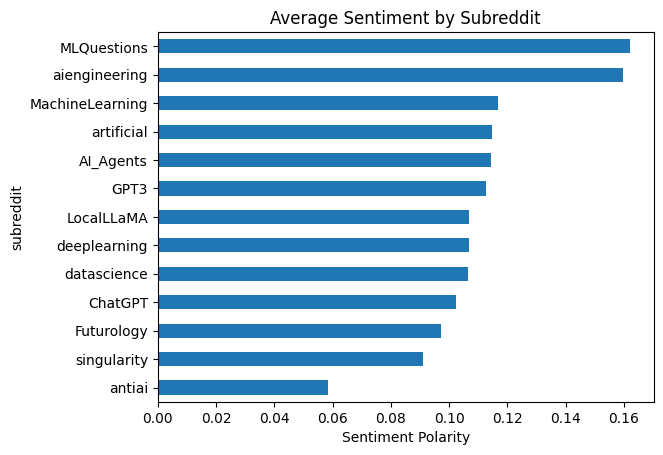

In [22]:
# Sentiment by subreddit
cleaned_df.groupby('subreddit')['sentiment_polarity'].mean().sort_values().plot(kind='barh')
plt.title('Average Sentiment by Subreddit')
plt.xlabel('Sentiment Polarity')
plt.show()

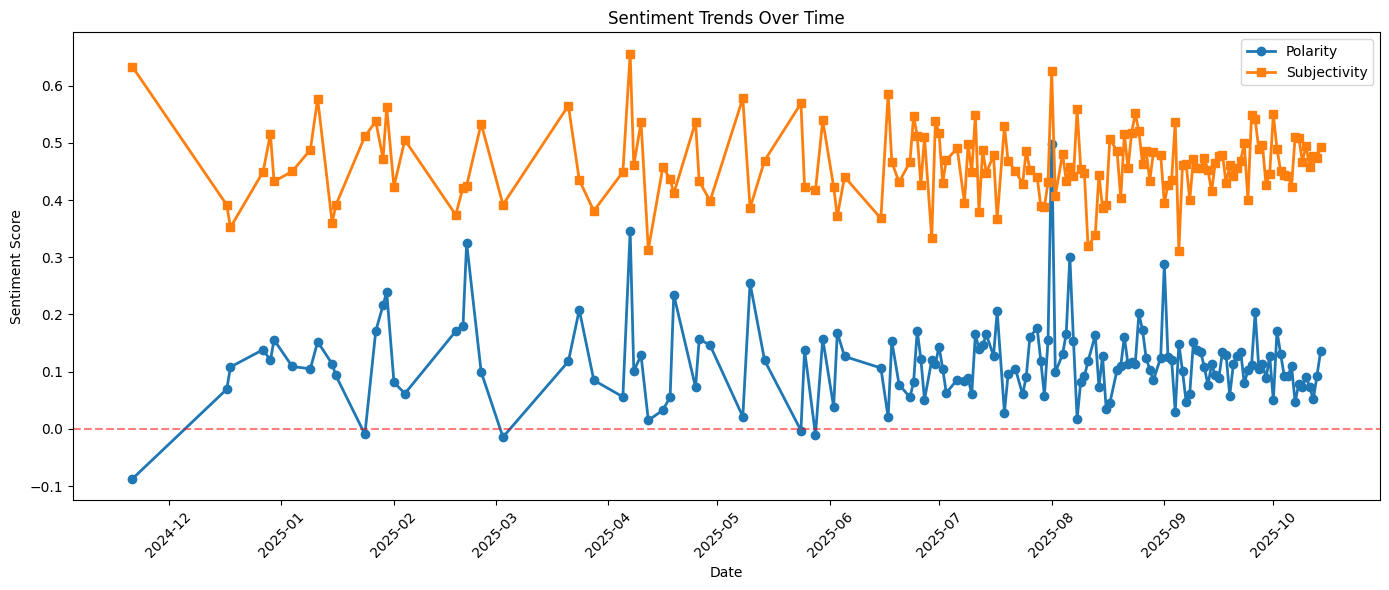

In [ ]:
# sentiment polarity vs subjectivity over time
plt.figure(figsize=(14, 6))
daily_sentiment = cleaned_df.groupby('date').agg({
    'sentiment_polarity': 'mean',
    'sentiment_subjectivity': 'mean'
}).reset_index()

plt.plot(daily_sentiment['date'], daily_sentiment['sentiment_polarity'], 
         marker='o', label='Polarity', linewidth=2)
plt.plot(daily_sentiment['date'], daily_sentiment['sentiment_subjectivity'], 
         marker='s', label='Subjectivity', linewidth=2)
plt.axhline(0, color='red', linestyle='--', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Trends Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('sentiment_over_time.png', dpi=300, bbox_inches='tight')
plt.show()

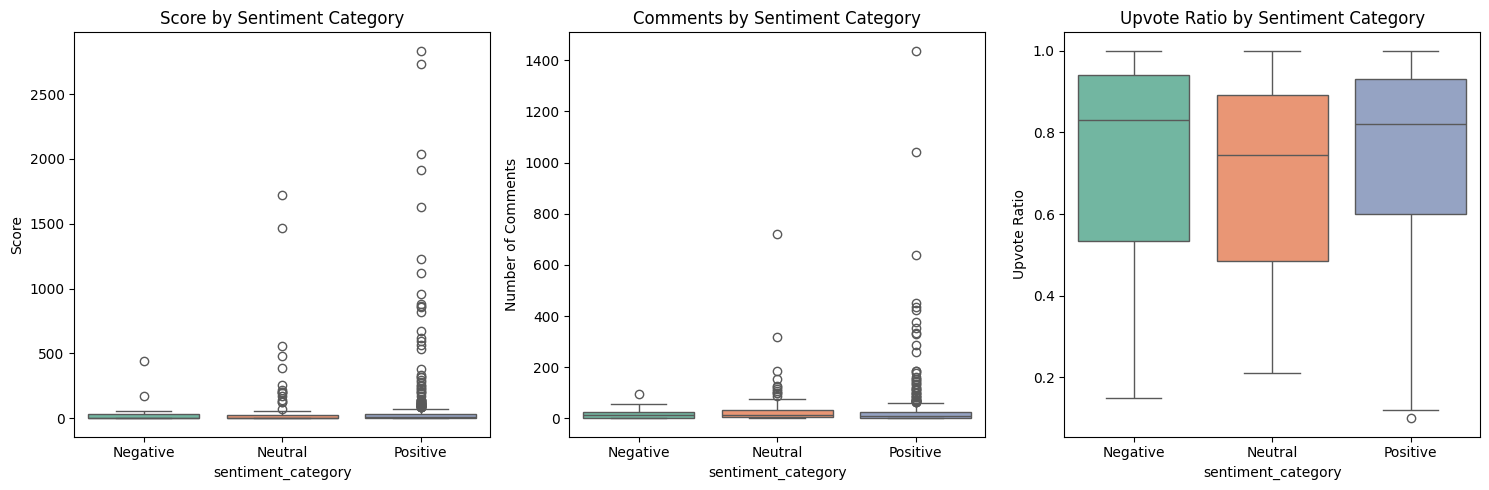

In [ ]:
# Boxplots of score, comments, upvote ratio by sentiment category
cleaned_df['sentiment_category'] = pd.cut(cleaned_df['sentiment_polarity'], 
                                          bins=[-1, -0.05, 0.05, 1],
                                          labels=['Negative', 'Neutral', 'Positive'])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(data=cleaned_df, x='sentiment_category', y='score', ax=axes[0], palette='Set2')
axes[0].set_title('Score by Sentiment Category')
axes[0].set_ylabel('Score')

sns.boxplot(data=cleaned_df, x='sentiment_category', y='num_comments', ax=axes[1], palette='Set2')
axes[1].set_title('Comments by Sentiment Category')
axes[1].set_ylabel('Number of Comments')

sns.boxplot(data=cleaned_df, x='sentiment_category', y='upvote_ratio', ax=axes[2], palette='Set2')
axes[2].set_title('Upvote Ratio by Sentiment Category')
axes[2].set_ylabel('Upvote Ratio')

plt.tight_layout()
# plt.savefig('boxplots_sentiment.png', dpi=300, bbox_inches='tight')
plt.show()


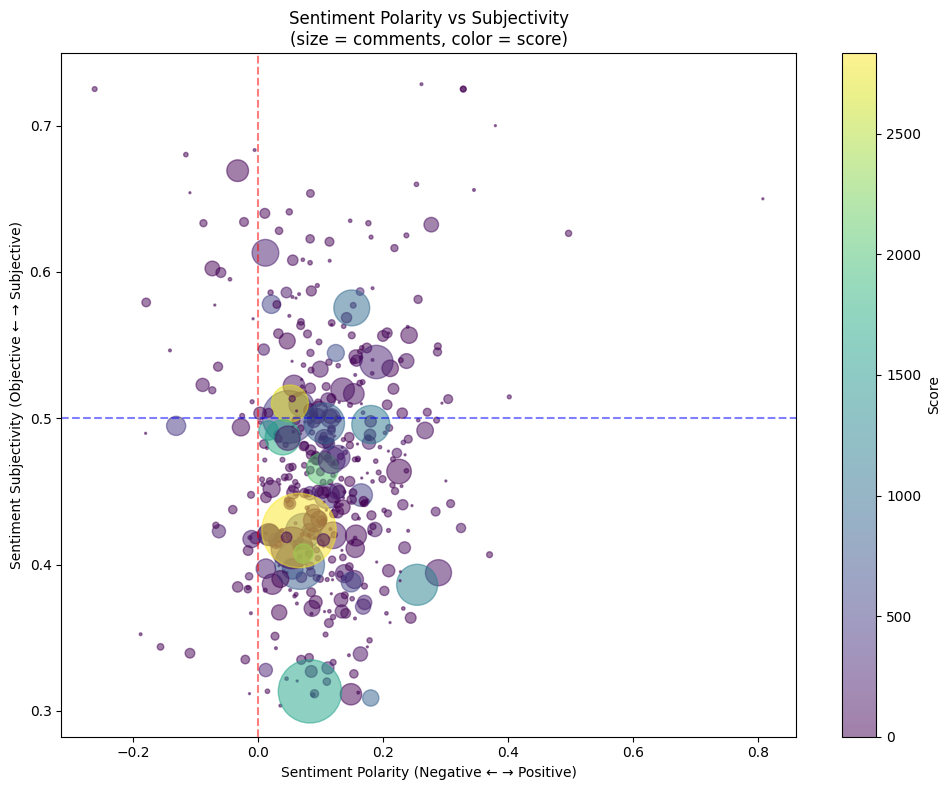

In [ ]:
# Polarity vs Subjectivity scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(cleaned_df['sentiment_polarity'], 
                     cleaned_df['sentiment_subjectivity'],
                     c=cleaned_df['score'], 
                     s=cleaned_df['num_comments']*2,
                     alpha=0.5, 
                     cmap='viridis')
plt.xlabel('Sentiment Polarity (Negative ← → Positive)')
plt.ylabel('Sentiment Subjectivity (Objective ← → Subjective)')
plt.title('Sentiment Polarity vs Subjectivity\n(size = comments, color = score)')
plt.axvline(0, color='red', linestyle='--', alpha=0.5)
plt.axhline(0.5, color='blue', linestyle='--', alpha=0.5)
plt.colorbar(scatter, label='Score')
plt.tight_layout()
# plt.savefig('polarity_vs_subjectivity.png', dpi=300, bbox_inches='tight')
plt.show()

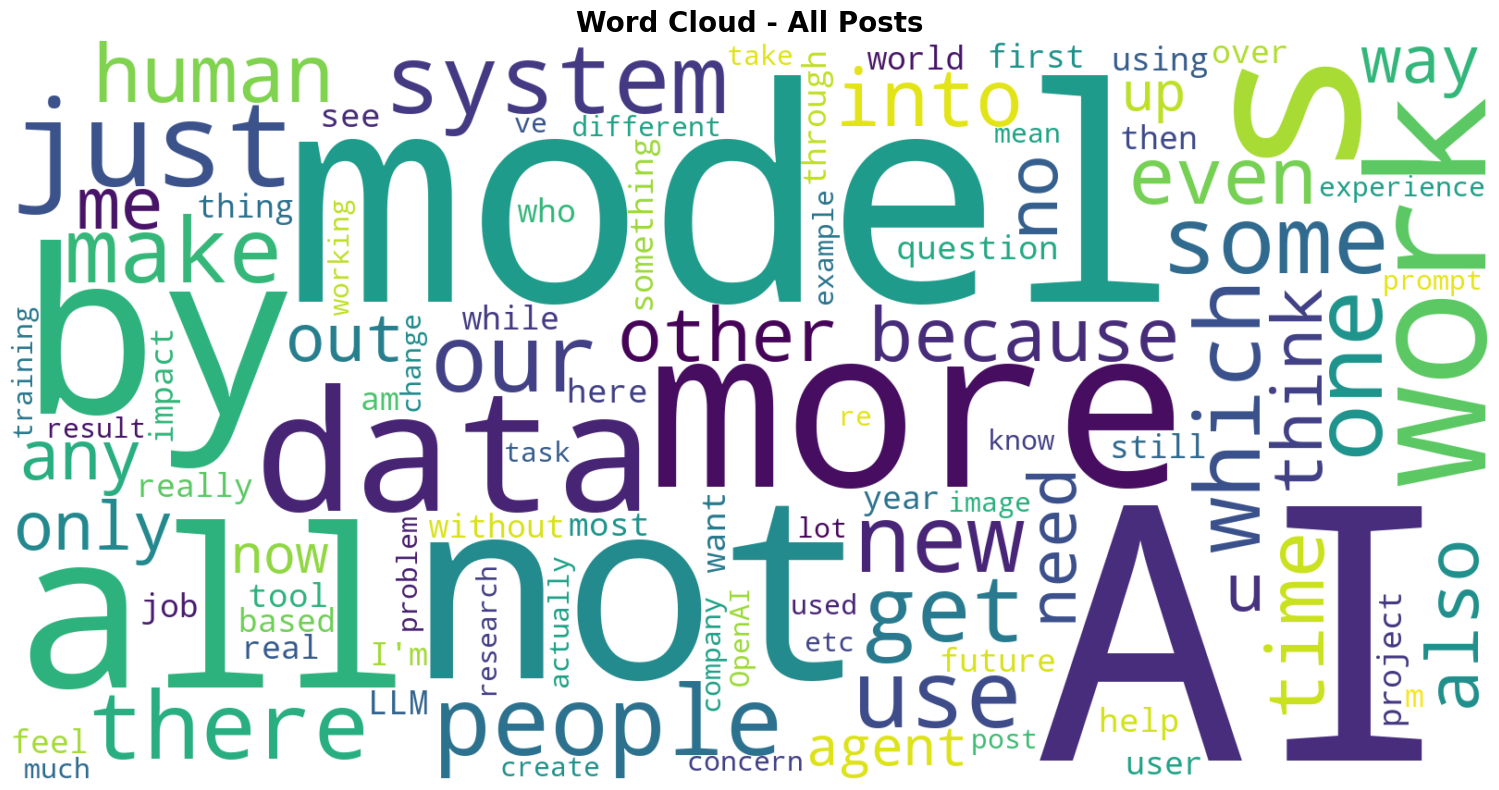

In [26]:
# Remove common stop words
stop_words = set(['I','you','we','the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 
                  'of', 'with', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'they', 'them', 'their',
                  'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could', 'how', 'why',
                  'should', 'may', 'might', 'must', 'can', 'this', 'that', 'these', 'those', 'like',
                  'what', 'from', 'about', 'where', 'when', 'your', 'my', 'so', 'if', 'as', 'it', 'its'])

# Overall word cloud
all_text = ' '.join(cleaned_df['selftext_clean'].astype(str))
wordcloud = WordCloud(width=1600, height=800, 
                     background_color='white',
                     stopwords=stop_words,
                     max_words=100,
                     colormap='viridis').generate(all_text)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - All Posts', fontsize=20, fontweight='bold')
plt.tight_layout()

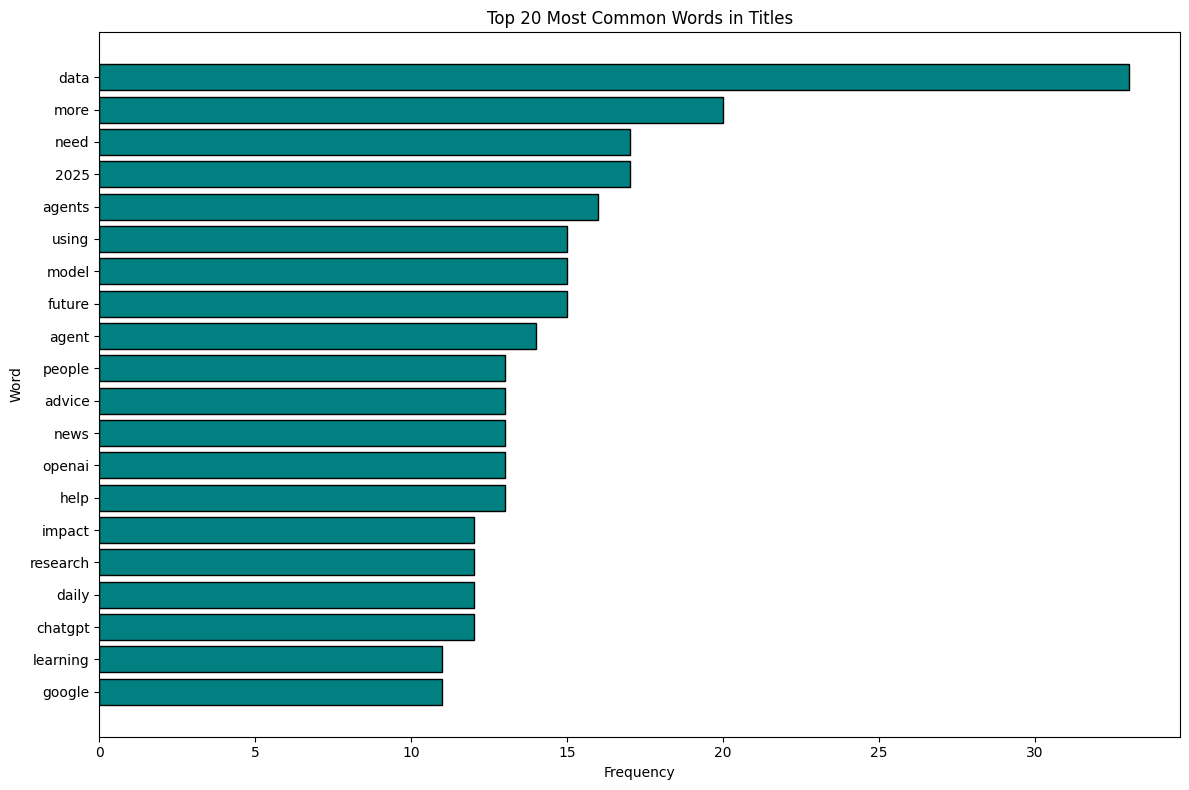

In [ ]:
# Top 20 Most Common Words
all_words = ' '.join(cleaned_df['title_clean'].astype(str)).lower().split()
filtered_words = [word for word in all_words if word not in stop_words and len(word) > 3]
word_counts = Counter(filtered_words).most_common(20)

if word_counts:
    words, counts = zip(*word_counts)
    
    plt.figure(figsize=(12, 8))
    plt.barh(words, counts, color='teal', edgecolor='black')
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.title('Top 20 Most Common Words in Titles')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    # plt.savefig('top_words.png', dpi=300, bbox_inches='tight')
    plt.show()

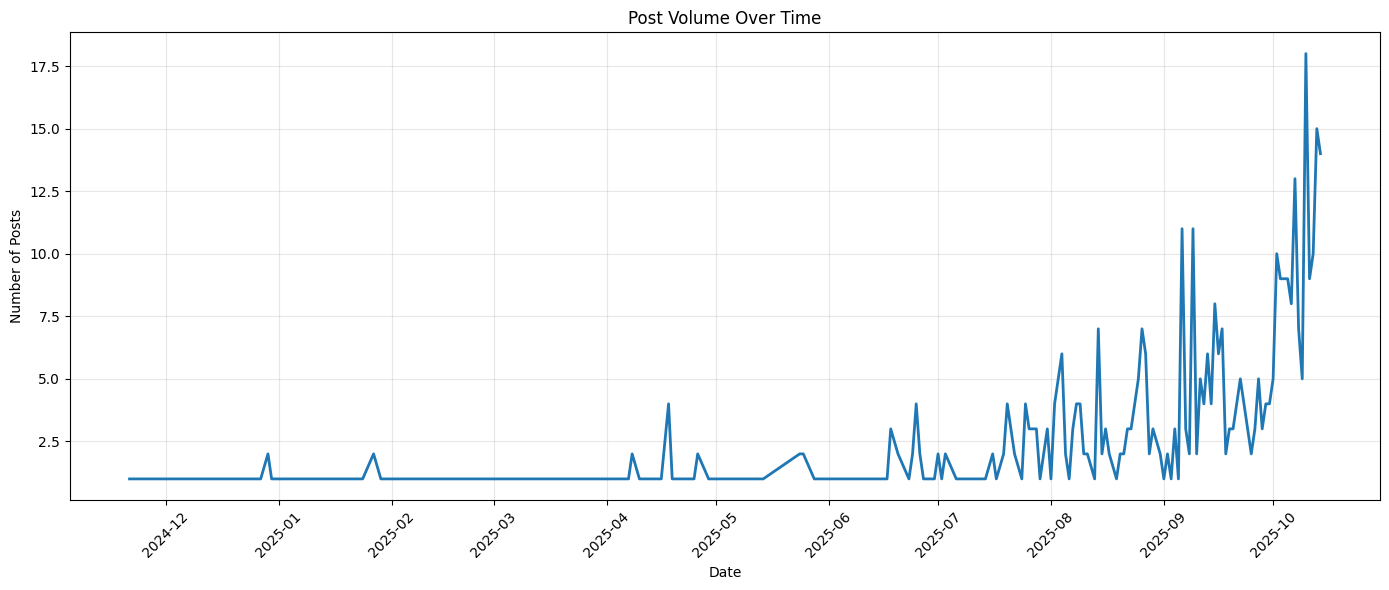

In [ ]:
# Post volume over time
plt.figure(figsize=(14, 6))
posts_per_day = cleaned_df.groupby('date').size()
plt.plot(posts_per_day.index, posts_per_day.values, linewidth=2)
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.title('Post Volume Over Time')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig('posts_over_time.png', dpi=300, bbox_inches='tight')
plt.show()